<a href="https://colab.research.google.com/github/ribesstefano/ml4justice-feature-predictor/blob/main/notebooks/ml4justice_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for Justice

## Setup and Imports

In [ ]:
!pip install -U datasets evaluate -qqq
!pip install -U accelerate -qqq
!pip install -U transformers -qqq
!pip install -U sentence-transformers -qqq
!pip install umap-learn -qqq
!pip install plotly==5.18.0 -qqq
!pip install -U optuna -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 36.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver

In [ ]:
!pip install bitsandbytes -qqq
!pip install peft -qqq
# !pip install git+https://github.com/huggingface/peft.git -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_from_disk

ds_name = "/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/sentenze-omicidio-stradale"
dataset = load_from_disk(ds_name)
dataset_df = dataset.to_pandas()
dataset

Dataset({
    features: ['corte', 'numero sentenza', 'localita commerciale o luogo di lavoro', 'vittima ferita', 'vittima eta avanzata', 'vittima era giovane', 'lavori stradali di manutenzione', 'guida senza patente valida imputato', 'guida senza patente valida vittima', 'piu imputati', 'strada a doppio senso di marcia', 'prossimita di un incrocio o curva', 'ostacolo prevedibile dalla vittima', 'ostacolo prevedibile dall imputato', 'eccesso verso imputato', 'eccesso verso vittima', 'neopat imputato', 'veicoli non abilitato a circolare o senza assicurazione vittima', 'veicoli non abilitato a circolare o senza assicurazione imputato', 'invasione corsia opposta', 'vittima ubriaca o drogata', 'imputato ubriaco o drogato', 'giovane eta imputato', 'vittima lesa/morta mentre lavorava', 'giorno', 'notte', 'segnaletica non visibile o assente', 'maltempo', "situazione economica precaria dell'imputato", 'spostamento corpo vittima', 'pers negativa imputat', 'violazione stop o semaforo o codice del

In [ ]:
dataset_df.to_csv("/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/original_df.csv", index=False)

## Text Utilities

In [ ]:
sentence_div = '|||'
section_div = '---'
section_name_div = ':::'

def clean_text(text):
    text = text.replace(sentence_div, "").replace(section_div, "")
    return text.replace(section_name_div, "").strip()

def clean_section_text(text):
    return text.replace(sentence_div, "").strip()

def get_senteces_from_text(text, clean=True):
    sentences = text.split(sentence_div)
    sentences = [s.split(section_name_div)[-1].strip() for s in sentences]
    if clean:
        sentences = [clean_section_text(s) for s in sentences]
    return sentences

def get_sections_from_text(text):
    sections = text.split(section_div)
    return {s.split(section_name_div)[0].strip(): s.split(section_name_div)[-1].strip() for s in sections}

for sample in dataset:
    text = sample['text']
    # sentences = get_senteces_from_text(text)
    # for s in sentences:
    #     print(s)
    sections = get_sections_from_text(text)
    for k, v in sections.items():
        print(k, clean_section_text(v))
    break

 
Incipit Cassazione penale sez. IV - 03/05/2023, n. 20253 Intestazione LA CORTE SUPREMA DI CASSAZIONE  SEZIONE QUARTA PENALE  Composta dagli Ill.mi Sigg.ri Magistrati: Dott. PICCIALLI Patrizia - Presidente - Dott. PEZZELLA Vincenzo - Consigliere - Dott. D'ANDREA Alessadro - Consigliere - Dott. MICCICHE'Loredana - rel. Consigliere - Dott. NOCERA Andrea - Consigliere - ha pronunciato la seguente:
SENTENZA sul ricorso proposto da:  H.M. nato il (Omissis); avverso la sentenza del 12/04/2022 della CORTE APPELLO di ANCONA visti gli atti, il provvedimento impugnato e il ricorso; udita la relazione svolta dal Consigliere LOREDANA MICCICHE'; lette le conclusioni Pubblico Ministero, in persona del Sostituto Procuratore ASSUNTA COCOMELLO; lette le conclusioni dell'avv. Emilio Perfetti per la parte civile Associazione Italiana familiari e vittime della strada.
RITENUTO IN FATTO 1. La Corte d'Appello di Ancona, con sentenza in data 12 aprile 2022, confermava la sentenza del GUP presso il Tribunale

In [ ]:
import random

random.seed(42)

def chunk_section(text, chunk_size=1024):
    """ Group the sections sentence into chunks of size chunk_size """
    # Split the text into sentences
    sentences = get_senteces_from_text(text)
    # Group the sentences into chunks of size chunk_size
    chunks = []
    curr_chunk = ""
    for sentence in sentences:
        if len(curr_chunk) + len(sentence) < chunk_size:
            curr_chunk += sentence + " "
        elif len(sentence) > chunk_size:
            if curr_chunk != "":
                # print(len(curr_chunk))
                chunks.append(curr_chunk)
            # Keep appending chunks of size chunk_size to the list, if the sentence is longer multiple times than chunk_size
            for i in range(0, len(sentence), chunk_size):
                # print(len(sentence[i:i+chunk_size]))
                chunks.append(sentence[i:i+chunk_size])
            curr_chunk = ""
        else:
            # print(len(curr_chunk))
            chunks.append(curr_chunk)
            curr_chunk = sentence + " "
    # print(len(curr_chunk))
    chunks.append(curr_chunk)
    return chunks

def get_facts(text):
    facts = get_sections_from_text(text)
    if 'Svolgimento del processo' in facts and 'Motivi della decisione' in facts:
        # text = facts['Svolgimento del processo'] + " " + facts['Motivi della decisione']
        text = facts['Svolgimento del processo']
    elif "RITENUTO IN FATTO" in facts:
        text = facts['RITENUTO IN FATTO']
    return text

def get_random_chunk(text, chunk_size=1024):
    """ Get a random chunk of size chunk_size from the text """
    text = clean_section_text(text)
    start = random.randint(0, max(0, len(text) - chunk_size - 1))
    # max_chunks = len(text) // chunk_size
    # start = random.randint(0, max_chunks - 1) * chunk_size
    end = start + min(chunk_size, len(text))
    return text[start:end]

for sample in dataset:
    text = sample['text']
    chunk = get_random_chunk(get_facts(text))
    print(chunk)
    break

ione dell'art. 141 C.d.S. poiché alla guida della sua autovettura, nel percorrere la strada provinciale n. (Omissis), alla guida dell'autocarro (Omissis), aveva tenuto una velocità non adeguata e comunque pari a 80 Km/h non commisurata allo stato dei luoghi, in considerazione delle condizioni metereologiche e dell'ora serale, e, affrontando un tratto di strada curvilineo, aveva perso il controllo del veicolo che, capovolgendosi, rovinava contro un manufatto, così cagionando la morte per gravissimo trauma cranico del F.C., seduto al lato passeggero anteriore.  La Corte territoriale, nel respingere i motivi di gravame, riteneva esaustiva la motivazione della sentenza di prime cure in ordine alle modalità del sinistro, su cui si soffermava rispondendo alle osservazioni mosse dall'appellante; confermava la statuizione del primo giudice in ordine al mancato riconoscimento delle circostanze attenuanti generiche, la durata della sanzione amministrativa accessoria e l'ammontare delle spese liq

## UMAP The Ruling Texts

### Get Similarity Score

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

sentence_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1').to("cuda")

In [ ]:
import numpy as np

def calculate_similarity(original_text, summary_text, factor_len=True):
    if isinstance(original_text, list) and isinstance(summary_text, list):
        text_embeddings = np.array(sentence_model.encode(original_text))
        summary_embeddings = np.array(sentence_model.encode(summary_text))
        text_embeddings = np.mean(text_embeddings, axis=0)
        summary_embeddings = np.mean(summary_embeddings, axis=0)
        embeddings = [text_embeddings, summary_embeddings]
    else:
        embeddings = sentence_model.encode([original_text, summary_text])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    if factor_len:
        # Length penalty factor: shorter summaries are better
        # This factor decreases as the summary gets longer
        length_penalty = len(original_text) / max(len(summary_text), 1)
        length_penalty = min(length_penalty, 1)  # Ensure it doesn't exceed 1
        # Combined score with a balance between similarity and brevity
        combined_score = similarity * length_penalty
        return combined_score
    else:
        return similarity

### Get UMAP-ed Embeddings

In [ ]:
from sklearn.preprocessing import StandardScaler
import umap
import plotly.express as px
import pandas as pd

def chunk_and_embed(text, chunk_size=512):
    # Chunk text and create embeddings
    sentences = get_senteces_from_text(text)
    chunks = []
    for sentence in sentences:
        chunks += chunk_section(sentence, chunk_size=chunk_size)
    embeddings = np.array(sentence_model.encode(chunks))
    # Return average embedding for the document
    return np.mean(embeddings, axis=0)

df = dataset.to_pandas()
# Get documents embeddings
embeddings = np.array([chunk_and_embed(doc) for doc in df['text']])
embeddings.shape

(81, 768)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

,numero sentenza,corte
0,20253,Cass. Penale
1,18284,Cass. penale
2,15832,Cass. penale
3,17209,Cass. penale
4,2112,Corte Appello Ancona
...,...,...
76,19944,cass. Penale
77,42017,cass. Penale
78,44364,cass. Penale
79,10107,cass. Penale


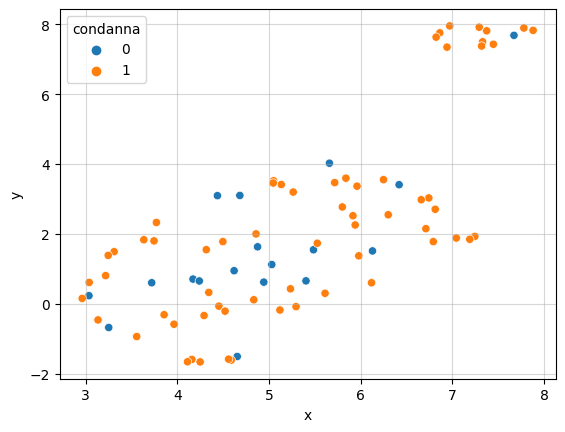

In [ ]:
# Scale embeddings before UMAP
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
# Apply UMAP
reducer = umap.UMAP(
    n_neighbors=4,
    min_dist=0.05,
    n_components=2,
    metric='cosine', # 'euclidean',
    init='pca', # Default: spectral
    n_epochs=1000, # Default: 500
    learning_rate=0.9, # Default: 1.0
    random_state=42,
    n_jobs=1,
)
umap_embeddings = reducer.fit_transform(scaled_embeddings)

# Step 3: Create Interactive HTML
df_umap = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
df = dataset.to_pandas().copy()
df['x'] = df_umap['x']
df['y'] = df_umap['y']

ax = sns.scatterplot(df, x='x', y='y', hue='condanna')
plt.grid('both', alpha=0.5)
plt.show()

custom_color_scale = ['blue', 'green', 'red', 'purple', 'orange']  # Example custom colors

# data_cols = [c for c in df.columns if c != 'text']
fig = px.scatter(df, x='x', y='y', color='condanna', hover_data=['numero sentenza', 'corte'], color_continuous_scale=custom_color_scale)
fig.write_html('sentenze_umap_interactive_plot.html')

## Summarizing Text

If you don't have reference summaries, evaluating the quality of generated summaries becomes more challenging, but there are still methods you can use:

### 1. **Fact Consistency Checks**
- **Extract Key Information**: Use Named Entity Recognition (NER) to extract key entities (names, dates, places) from both the original text and the summary. Compare them to check if the summary accurately represents crucial facts from the original text.

### 2. **Semantic Similarity**
- **Cosine Similarity**: Compute the cosine similarity between the vector representations of the original text and the summary. High cosine similarity indicates that the summary retains the core meaning of the original text.
- **BERT-based Similarity**: Use models like Sentence-BERT to encode both texts and summaries into embeddings, then calculate cosine similarity.

### 3. **Readability and Coherence**
- **Readability Scores**: Use metrics like Flesch Reading Ease or Gunning Fog Index to assess how readable your summaries are.
- **Manual Inspection**: Nothing beats a good old-fashioned read-through. Even a cursory glance can reveal glaring issues with coherence or relevance.

### Example Implementations

#### Fact Consistency Check
```python
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

original_text = "Your original text here"
summary_text = "Your summary here"

original_entities = extract_entities(original_text)
summary_entities = extract_entities(summary_text)

# Compare entities for consistency
```

#### Semantic Similarity Using BERT
First, install the Sentence Transformers package:

```bash
pip install sentence-transformers
```

Then, use the following code:

```python
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_similarity(text1, text2):
    embeddings = model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

original_text = "Your original text here"
summary_text = "Your summary here"

similarity_score = calculate_similarity(original_text, summary_text)
print("Semantic Similarity Score:", similarity_score)
```

### Notes
- **Fact Consistency**: Be aware that this method doesn't assess the quality of writing or how well the summary captures nuanced themes.
- **Semantic Similarity**: High semantic similarity doesn't guarantee that all important points are included in the summary.
- **Manual Inspection**: Even though it's time-consuming, it's a good way to catch errors that automated methods might miss.

---

Yes, you can use Optuna, a hyperparameter optimization framework, to tune the generation parameters of your model to maximize the scores such as semantic similarity or other custom metrics you've established for summary quality. The process involves defining an objective function that returns the metric you want to optimize, and then running Optuna to find the best hyperparameters.

Here's a basic example to illustrate how you might set this up:

### Installing Optuna

First, install Optuna:

```bash
pip install optuna
```

### Defining the Objective Function

Your objective function will generate summaries using the model with varying hyperparameters, and then compute the desired score for those summaries. As an example, let's use semantic similarity as the score to be maximized:

```python
import optuna
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import your_model  # Import your summarization model

model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_similarity(text1, text2):
    embeddings = model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

def objective(trial):
    # Define the hyperparameters to tune
    min_new_tokens = trial.suggest_int('min_new_tokens', 10, 50)
    temperature = trial.suggest_float('temperature', 0.7, 1.5)
    num_beams = trial.suggest_int('num_beams', 3, 10)

    # Generate summary with current set of hyperparameters
    summary = your_model.generate_summary(your_text, min_new_tokens, temperature, num_beams)

    # Compute the score you want to maximize/minimize
    score = calculate_similarity(your_text, summary)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can change the number of trials

print(study.best_params)
```

### Notes

1. **Model Generation Function**: Replace `your_model.generate_summary` with the actual function you use to generate summaries, passing the appropriate hyperparameters.

2. **Text Input**: `your_text` should be the text you want to summarize.

3. **Custom Metric**: In this example, I've used semantic similarity as the metric. You can replace this with any metric that suits your needs, such as fact consistency checks or a combination of different metrics.

4. **Trial and Error**: Hyperparameter optimization can be computationally expensive. You might need to adjust the number of trials and the range of hyperparameters based on available computational resources and the time you're willing to invest.

5. **Model Constraints**: Ensure that the ranges of hyperparameters you choose are compatible with your model's capabilities and limitations.

This approach allows you to systematically and efficiently search the hyperparameter space to find the set of values that best improves your summary quality according to your chosen metric.

In [ ]:
# !pip install spacy -qqq
# !python -m spacy download it_core_news_lg

---

In [ ]:
# import spacy

# nlp = spacy.load("it_core_news_lg")

# def extract_entities(text):
#     doc = nlp(text)
#     entities = set()
#     for ent in doc.ents:
#         entities.add((ent.text.strip(), ent.label_))
#     return entities

# def fact_consistency_score(original_text, summary_text):
#     original_entities = extract_entities(original_text)
#     summary_entities = extract_entities(summary_text)
#     print(f"original_entities: {original_entities}")
#     print(f"summary_entities: {summary_entities}")
#     if not original_entities:
#         return 0.0  # Avoid division by zero

#     matching_entities = original_entities.intersection(summary_entities)
#     score = len(matching_entities) / len(original_entities)
#     return score

### Setup Summary Pipeline

In [ ]:
from transformers import pipeline

pipe = pipeline("summarization", model="ARTeLab/mbart-summarization-mlsum", device="cuda", use_fast=True)

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

In [ ]:
def get_summary(text, batch_size=4, **kwargs):
    # summaries = pipe(text, **kwargs)
    summaries = []
    for out in pipe(text, batch_size=batch_size, **kwargs):
        summaries.append(out['summary_text'])
    return summaries

In [ ]:
text = "summarize: Con l'undicesimo motivo, ha dedotto analoghi vizi, sempre relativamente al punto della decisione inerente alla ripartizione delle percentuali di responsabilità, contestando che l'imputato avesse avuto una visuale libera, tale da consentirgli di avvistare i mezzi sin dalla loro uscita dalla galleria, tenuto conto dell'andamento in salita della strada, anche in questo caso riportando fotogrammi a dimostrazione degli assunti difensivi. "
text = "summarize: ri commessi principalmente dal consulente del pubblico ministero che avrebbe sottodimensionato la velocità della moto, calcolandola solo in funzione dell'energia strettamente necessaria per produrre la deformazione del mezzo, prescindendo da tutte le altre quantità di energia dispersa nell'urto e così errando anche sul calcolo della velocità dell'auto che è stata posta lungo una traiettoria che si assume palesemente incompatibile con il suo reale percorso."

get_summary(
    text,
    do_sample=True,
    min_new_tokens=16,
    num_beams=5,
    temperature=1.2,
)

Your max_length is set to 1024, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


["Il consulente del ministero ha sottodimensionato la velocità della moto, calcolandola solo in funzione dell'energia necessaria per produrre la deformazione del veicolo."]

In [ ]:
for i, sample in enumerate(dataset):
    facts = get_sections_from_text(sample['text'])
    if 'Svolgimento del processo' in facts and 'Motivi della decisione' in facts:
        # text = facts['Svolgimento del processo'] + " " + facts['Motivi della decisione']
        text = facts['Svolgimento del processo']
    elif "RITENUTO IN FATTO" in facts:
        text = facts['RITENUTO IN FATTO']

    chunk_size = 1024
    chunks = chunk_section(text, chunk_size=512)
    rand_text = get_random_chunk(text, chunk_size=chunk_size)
    texts = [rand_text] + chunks
    print(f"RANDOM: {rand_text[:100]}... (len: {len(rand_text)})")
    print("num chunks:", len(chunks))
    print("max len:", max([len(s) for s in chunks]))

    # summaries = get_summary(texts)
    # for s, t in zip(summaries, texts):
    #     print('-' * 80)
    #     print("ORIGINAL:", t)
    #     print("SUMMARY: ", s)

    if i > 3:
        break

RANDOM: Appello di Ancona, con sentenza in data 12 aprile 2022, confermava la sentenza del GUP presso il Tri... (len: 1024)
num chunks: 9
max len: 512
RANDOM: to delle spese di costituzione e difesa nei confronti delle parti civili suddette. .  Avverso la pre... (len: 1024)
num chunks: 14
max len: 512
RANDOM: sta.  Con il sesto motivo, in stretta connessione con la precedente doglianza, ha dedotto analogo vi... (len: 1024)
num chunks: 27
max len: 512
RANDOM: o riferimento alla regola della destra rigorosa nella circolazione stradale, si è infatti affermato ... (len: 1024)
num chunks: 19
max len: 513
RANDOM: do la quale sarebbe mancata la prova del comportamento imprudente del D., opponendovi a smentita le ... (len: 1024)
num chunks: 19
max len: 513


### Optuna-Based Summarization

In [ ]:
import optuna
import pandas as pd
import torch
import warnings

In [ ]:
batch_size = 2
chunk_size = 512

def objective(trial, dataset):
    # Define the hyperparameters to tune
    min_new_tokens = trial.suggest_int('min_new_tokens', 10, 50)
    temperature = trial.suggest_float('temperature', 0.7, 1.5)
    num_beams = trial.suggest_int('num_beams', 3, 10)
    top_k = trial.suggest_int('top_k', 50, 100, 10)
    # DataFrame to store text, summary, and score
    summary_data = []
    for sample in dataset:
        text = clean_text(get_facts(sample['text']))
        chunks = chunk_section(text, chunk_size=chunk_size)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            summaries = get_summary(
                chunks,
                batch_size=batch_size,
                do_sample=True,
                min_new_tokens=min_new_tokens,
                num_beams=num_beams,
                temperature=temperature,
                top_k=top_k,
            )
        # Compute the score for each summary
        score = calculate_similarity(chunks, summaries)
        # Append to DataFrame
        sample['summary'] = '. '.join(summaries).replace('..', '.')
        sample['score'] = score
        summary_data.append(sample)
    summary_data = pd.DataFrame(summary_data)
    # Calculate average score for this trial
    avg_score = summary_data['score'].mean()
    # Save DataFrame to CSV
    base_dir = "/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/summaries/"
    filename = f"{base_dir}/trial_{trial.number}_score_{avg_score:.3f}.csv"
    summary_data.to_csv(filename, index=False)
    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, dataset), n_trials=10)  # You can change the number of trials
print(study.best_params)
print(study.best_trial)

Streaming output truncated to the last 5000 lines.
Your max_length is set to 1024, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 1024, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)
Your max_length is set to 1024, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)
Your max_length is set to 1024, but your input_length is only 2. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_le

In [ ]:
facts = [clean_text(get_facts(t)) for t in dataset['text']]
if 'facts' in dataset.column_names:
    dataset = dataset.remove_columns('facts')
dataset = dataset.add_column('facts', facts)

In [ ]:
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

# best_gen_kwargs = {
#     'min_new_tokens': 50,
#     'temperature': 1.461671417648644,
#     'num_beams': 10,
#     'top_k': 50,
# }

best_gen_kwargs = {
    'min_new_tokens': 41,
    'temperature': 0.932732254084788,
    'num_beams': 10,
    'top_k': 90,
} # Best is trial 8 with value: 0.9331906938258513.

# def data():
#     for sample in dataset:
#         yield sample['facts']

# summaries = []
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     for i, sample in tqdm(enumerate(facts), total=len(facts)):
#         summary = pipe(sample, **best_gen_kwargs)[0]['summary_text']
#         print(sample)
#         print(summary)
#         print('-' * 80)
#         summaries.append(summary)
#         if i > 5:
#             break

summaries = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for summary in tqdm(pipe(KeyDataset(dataset, 'facts'), batch_size=8, **best_gen_kwargs), total=len(dataset)):
        summaries.append(summary)
summaries

  0%|          | 0/81 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
df = dataset.to_pandas()
df['facts'] = facts
df['summary'] = [s['summary_text'] for s in summaries]
base_dir = "/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/summaries/"
filename = f"{base_dir}/dataset_with_summaries.csv"
df.to_csv(filename, index=False)

TypeError: ignored

## Training

### Load Dataframes and Setup Train/Val/Test Datasets

Load dataframes containing the summaries and rank them based on their score:

In [ ]:
import pandas as pd

dfs = [
    'trial_0_score_0.91.csv',
    'trial_1_score_0.91.csv',
    'trial_2_score_0.91.csv',
    'trial_3_score_0.92.csv',
    'trial_4_score_0.93.csv',
    'trial_5_score_0.93.csv',
    'trial_6_score_0.91.csv',
    'trial_7_score_0.92.csv',
    'trial_8_score_0.93.csv',
]

base_dir = "/content/drive/MyDrive/Colab Notebooks/ml_for_justice/data/summaries/"
summary_df = pd.concat([pd.read_csv(base_dir + f) for f in dfs])
label_columns = [col for col in summary_df.columns if col not in ['numero sentenza', 'filename', 'text', 'raw text', 'corte', 'target', 'casi', 'condanna', 'colpa', 'labels', 'score', 'summary', 'giorno']]
label_columns.sort()
print(label_columns)
summary_df[['text', 'summary', 'score']]

['andamento retromarcia', 'attraversamento corretto della vittima', 'attraversamento vittima con semaforo rosso', 'attraverso vittima senza strisce o sbucata improvvisamente', 'centro abitato', 'disattenzione, esempio: colpo di sonno', 'eccesso verso imputato', 'eccesso verso vittima', 'fuga imputato', 'giovane eta imputato', 'guida brusca o manovra brusca della vittima', 'guida brusca o manovra brusca imputato', 'guida senza patente valida imputato', 'guida senza patente valida vittima', 'imputato perde controllo', 'imputato ubriaco o drogato', 'invasione corsia opposta', 'lavori stradali di manutenzione', 'localita commerciale o luogo di lavoro', 'maltempo', 'mancanza cintura di sicurezza o casco vittima', 'mezzo scarico', 'neopat imputato', 'notte', 'omissione distanza di sicurezza', 'ostacolo prevedibile dall imputato', 'ostacolo prevedibile dalla vittima', 'pers negativa imputat', 'piu imputati', 'poca illuminazione o scarsa visibilita', 'presenza rimorchio imputato', 'prossimita 

,text,summary,score
0,--- Incipit ::: Cassazione penale sez. IV - 0...,"La Corte d'Appello di Ancona, con sentenza nel...",0.897048
1,--- Incipit ::: Cassazione penale sez. IV - 2...,La Corte territoriale ha condiviso la valutazi...,0.925078
2,--- Incipit ::: Cassazione penale sez. IV - 0...,Il giudice ha ridotto le spese per omicidio co...,0.942574
3,--- Incipit ::: Cassazione penale sez. IV - 0...,Il ciclista è stato condannato a un reato di c...,0.910248
4,"--- Incipit ::: Corte appello - Ancona, 23/01...","Incipit Corte d'appello di Ancona, 23/01/2023,...",0.951426
...,...,...,...
76,--- Incipit ::: Cassazione penale sez. IV - 2...,L'imputata era stata contestata la colpa gener...,0.910752
77,--- Incipit ::: Cassazione penale sez. IV - 2...,L'imputato è stato ritenuto responsabile dell'...,0.915568
78,--- Incipit ::: Cassazione penale sez. IV - 2...,La sentenza di assoluzione del primo giudice c...,0.934725
79,"--- Incipit ::: OneLEGALECass. pen., Sez. IV,...",La Corte d'appello di Napoli conferma la sente...,0.949607


In [ ]:
row = summary_df.iloc[0, :]
features = [k for k, v in row[label_columns].where(row[label_columns] > 0).to_dict().items() if v > 0]
for f in features:
    print(f)
print('-' * 80)
chunk = get_random_chunk(clean_text(get_facts((row['text']))), chunk_size=2048)
chunk = clean_text(get_facts((row['text'])))
len(tokenizer(chunk, truncation=True, padding="max_length")['input_ids'])

eccesso verso imputato
giovane eta imputato
maltempo
notte
ostacolo prevedibile dall imputato
pers negativa imputat
prossimita di un incrocio o curva
situazione economica precaria dell'imputato
spostamento corpo vittima
violazione regole di prudenza o negligenza o imperizia imputato
violazione stop o semaforo o codice della strada da parte imputato
--------------------------------------------------------------------------------


512

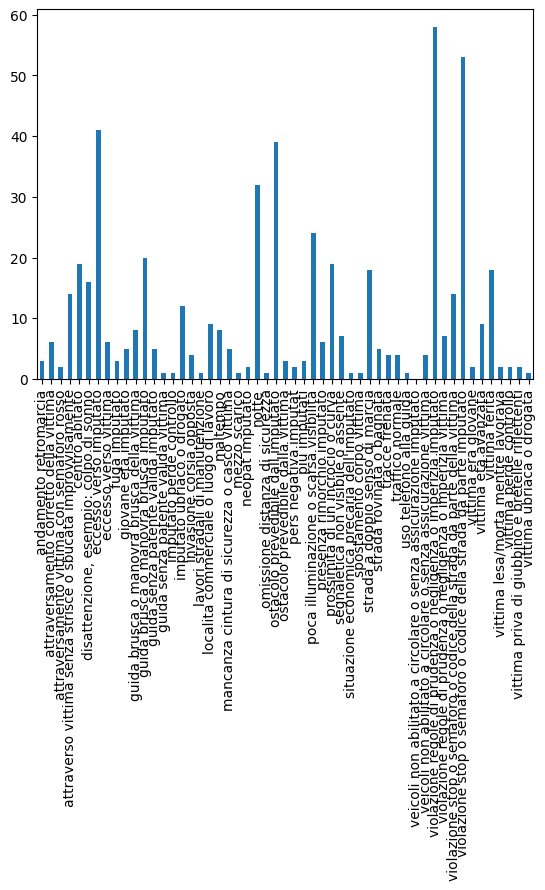

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tmp = summary_df.drop_duplicates(subset='numero sentenza')
tmp = tmp[label_columns].sum()
tmp.plot(kind='bar')
plt.show()

Split the dataframe:

In [ ]:
test_size = 10
test_df = summary_df.drop_duplicates(subset='numero sentenza').sample(n=test_size, random_state=42)
test_df

,corte,numero sentenza,localita commerciale o luogo di lavoro,vittima ferita,vittima eta avanzata,vittima era giovane,lavori stradali di manutenzione,guida senza patente valida imputato,guida senza patente valida vittima,piu imputati,...,tracce frenata,fuga imputato,uso telefono alla guida,vittima perde controllo,imputato perde controllo,condanna,filename,text,summary,score
30,Cass. penale,24175,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,24175 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...,"C.M., condannato a anni e mesi di reclusione, ...",0.871286
0,Cass. Penale,20253,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,20253 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...,"La Corte d'Appello di Ancona, con sentenza nel...",0.897048
22,Cass. penale,6366,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,cass pen 6366.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...,L'imputato M.C. è stato condannato per il reat...,0.934952
31,Cass. penale,20956,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,20956 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...,La Corte di Appello di Palermo ha confermato i...,0.930339
18,Cass. penale,474,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,cass penale 474.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...,Il sinistro è stato causato da un reato di cui...,0.956120
28,Cass. penale,26293,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,26293 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 3...,I candidati alle elezioni comunali si riunisco...,0.942345
10,Cass. penale,40050,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,40050 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...,La sentenza del tribunale di Trieste conferma ...,0.924613
71,cass. Penale,121,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,Cass. pen. 121.pdf,"--- Incipit ::: OneLEGALECass. pen., Sez. IV,...","L'odierno ricorrente C.L., con sentenza del9/1...",0.909207
4,Corte Appello Ancona,2112,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,2112 corte appello Ancona.pdf,"--- Incipit ::: Corte appello - Ancona, 23/01...","Incipit Corte d'appello di Ancona, 23/01/2023,...",0.951426
12,Cass. penale,42018,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,42018 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...,La Corte d'appello di Caltanissetta con la pro...,0.915349


In [ ]:
score_threshold = 0.8
test_size = 10
# Get the entries that have a score higher than a threshold
best_df = summary_df[summary_df['score'] > score_threshold]
test_idx = test_df['numero sentenza'].tolist()
# Sample w/out replacement N unique numero sentenze
# Get the entries that have a score higher than a threshold and that are not in the test set
train_val_df = best_df[~best_df['numero sentenza'].isin(test_idx)]
test_df = test_df.drop(columns=['summary', 'score']).drop_duplicates(subset='numero sentenza')
print(len(test_df))
print(len(train_val_df))
display(train_val_df.head(5))
display(test_df.head(5))

10
619


,corte,numero sentenza,localita commerciale o luogo di lavoro,vittima ferita,vittima eta avanzata,vittima era giovane,lavori stradali di manutenzione,guida senza patente valida imputato,guida senza patente valida vittima,piu imputati,...,tracce frenata,fuga imputato,uso telefono alla guida,vittima perde controllo,imputato perde controllo,condanna,filename,text,summary,score
10,Cass. penale,40050,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,40050 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...,La sentenza del tribunale di Trieste conferma ...,0.924613
11,Cass. penale,18802,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,18802 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 1...,La Corte di Appello di Roma ha pronunciato nei...,0.938544
12,Cass. penale,42018,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,42018 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...,La Corte d'appello di Caltanissetta con la pro...,0.915349
13,Trib. Roma,1934,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1934 trib Roma.pdf,--- Incipit ::: nel procedimento penale n. GI...,Incipit nel procedimento penale n. GIP definit...,0.953766
14,Cass. penale,18781,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18781 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 1...,M.S. dal delitto di omicidio colposo con inoss...,0.925262


,corte,numero sentenza,localita commerciale o luogo di lavoro,vittima ferita,vittima eta avanzata,vittima era giovane,lavori stradali di manutenzione,guida senza patente valida imputato,guida senza patente valida vittima,piu imputati,...,presenza rimorchio imputato,andamento retromarcia,tracce frenata,fuga imputato,uso telefono alla guida,vittima perde controllo,imputato perde controllo,condanna,filename,text
0,Cass. Penale,20253,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,20253 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...
1,Cass. penale,18284,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,18284 cass. pen.pdf,--- Incipit ::: Cassazione penale sez. IV - 2...
2,Cass. penale,15832,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,15832 cass penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...
3,Cass. penale,17209,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,17209 Cass. penale.pdf,--- Incipit ::: Cassazione penale sez. IV - 0...
4,Corte Appello Ancona,2112,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2112 corte appello Ancona.pdf,"--- Incipit ::: Corte appello - Ancona, 23/01..."


In [ ]:
import random

random.seed(42)

train_val_entries = []
num_rand_chunks = 16
chunk_size = 512

for i, row in train_val_df.iterrows():
    facts = get_facts(clean_text(row['text']))
    summary = clean_text(row['summary'])
    for j in range(num_rand_chunks):
        text_chunk = get_random_chunk(facts, chunk_size=chunk_size)
        row['chunk'] = text_chunk
        train_val_entries.append(row.copy())
        summary_chunk = get_random_chunk(summary, chunk_size=chunk_size)
        row['chunk'] = summary_chunk
        train_val_entries.append(row.copy())

train_val_df = pd.DataFrame(train_val_entries)
for i, chunk in enumerate(train_val_df['chunk'].tolist()):
    print(chunk)
    print('-' * 80)
    if i > 20:
        break

Schettino.  P.G., P.C. in proc. Schettino, Rv. 270779).  Invero, l'obbligo di "circolare sulla parte destra della carreggiata e in prossimità del margine destro della.  medesima, anche quando la strada è libera", previsto dall'art. 143 C.d.S., ha la finalità di garantire un'andatura corretta e regolare nell'ambito della propria corsia di marcia per la tutela del veicolo procedente e degli altri che la percorrono (Sez. 4, n. 50024 del 04/10/2017 - dep. 31/10/2017, Delfino, Rv. 271490).  Va certamente escluso
--------------------------------------------------------------------------------
. Al L. è stato ascritto di aver mantenuto una velocità superiore a quella prevista nel tratto stradale, ma non ha adeguato le condizioni del luogo Silvia Fantinel ha deciso di chiudere la linea di mezzeria, ma la linea di mezzeria ha sconvolto l'investimento della giovane, autrice dal canto suo di un comportamento imprudente L'esperto del P.M. ha sostenuto che la velocità che (probabilmente) avrebbe re

The Hugging Face dataset needs to be organized in a hierarchical way, with `text` and `labels`. Here is a function to do that based on a given dataframe:

In [ ]:
from datasets import Dataset, Features, ClassLabel, Value, Sequence
from typing import Literal

def build_dataset_from_pandas(df, hierarchical=False, text_column_name: Literal['text', 'summary'] = 'text'):
    if hierarchical:
        # Each entry of df['labels'] shall be a list of the column names whose indexes are 1
        df['labels'] = df[label_columns].apply(lambda x: [k for k, v in x.to_dict().items() if v == 1], axis=1)
        # Convert DataFrame to dictionary
        data_dict = {
            'text': [clean_text(t) for t in df[text_column_name].tolist()],
            'labels': df['labels'].tolist(),
        }
        # Define the features with nested structure
        features = Features({
            'text': Value('string'),
            'labels': Sequence(ClassLabel(names=label_columns)),
        })
        # Create the dataset
        return Dataset.from_dict(data_dict, features=features)
    data_dict = {k: df[k].tolist() for k in label_columns if k in df.columns}
    data_dict['text'] = [clean_text(t) for t in df[text_column_name].tolist()]
    return Dataset.from_dict(data_dict)

test_dataset = build_dataset_from_pandas(test_df)
test_dataset

Dataset({
    features: ['andamento retromarcia', 'attraversamento corretto della vittima', 'attraversamento vittima con semaforo rosso', 'attraverso vittima senza strisce o sbucata improvvisamente', 'centro abitato', 'disattenzione, esempio: colpo di sonno', 'eccesso verso imputato', 'eccesso verso vittima', 'fuga imputato', 'giovane eta imputato', 'guida brusca o manovra brusca della vittima', 'guida brusca o manovra brusca imputato', 'guida senza patente valida imputato', 'guida senza patente valida vittima', 'imputato perde controllo', 'imputato ubriaco o drogato', 'invasione corsia opposta', 'lavori stradali di manutenzione', 'localita commerciale o luogo di lavoro', 'maltempo', 'mancanza cintura di sicurezza o casco vittima', 'mezzo scarico', 'neopat imputato', 'notte', 'omissione distanza di sicurezza', 'ostacolo prevedibile dall imputato', 'ostacolo prevedibile dalla vittima', 'pers negativa imputat', 'piu imputati', 'poca illuminazione o scarsa visibilita', 'presenza rimorchio

Following [this guide](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb) (and [this one](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb) sometimes...).

In [ ]:
labels = label_columns # [label for label in test_dataset.features.keys() if label not in ['text']]
num_labels = len(labels)
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}
labels

['andamento retromarcia',
 'attraversamento corretto della vittima',
 'attraversamento vittima con semaforo rosso',
 'attraverso vittima senza strisce o sbucata improvvisamente',
 'centro abitato',
 'disattenzione, esempio: colpo di sonno',
 'eccesso verso imputato',
 'eccesso verso vittima',
 'fuga imputato',
 'giovane eta imputato',
 'guida brusca o manovra brusca della vittima',
 'guida brusca o manovra brusca imputato',
 'guida senza patente valida imputato',
 'guida senza patente valida vittima',
 'imputato perde controllo',
 'imputato ubriaco o drogato',
 'invasione corsia opposta',
 'lavori stradali di manutenzione',
 'localita commerciale o luogo di lavoro',
 'maltempo',
 'mancanza cintura di sicurezza o casco vittima',
 'mezzo scarico',
 'neopat imputato',
 'notte',
 'omissione distanza di sicurezza',
 'ostacolo prevedibile dall imputato',
 'ostacolo prevedibile dalla vittima',
 'pers negativa imputat',
 'piu imputati',
 'poca illuminazione o scarsa visibilita',
 'presenza rim

### Setup Model and Tokenizer (and PEFT)

Start from the tokenizer:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "iproskurina/tda-itabert-ita-cola"
# model_name = "ARTeLab/mbart-summarization-mlsum"
# model_name = "papluca/xlm-roberta-base-language-detection" # Best one so far
model_name = "classla/xlm-roberta-base-multilingual-text-genre-classifier"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    max_length=512, # At least 512
)

tokenizer_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

### Tokenize Datasets

Let's setup a CV generator:

In [ ]:
import torch
import numpy as np
from datasets import Features, Value, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold


def preprocess_function(examples, text_column_name="text"):
    # Take a batch of texts
    text = [text for text in examples["text"]]
    # Encode them
    encoding = tokenizer(text, padding="max_length", truncation=True)
    # Add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # Create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # Fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    encoding["labels"] = labels_matrix.tolist()
    return encoding


def k_fold_tokenized_datasets(n_splits=5, duplicate_train_set=5):
    gkf = GroupKFold(n_splits=n_splits)
    k_splits = gkf.split(train_val_df, groups=train_val_df['numero sentenza'])

    # Tokenize test dataset and get the columns to remove
    test_dataset = build_dataset_from_pandas(test_df)
    cols_to_remove = [c for c in test_dataset.column_names if c not in labels] + labels
    test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=cols_to_remove)

    for train_idx, val_idx in k_splits:
        train_df = train_val_df.iloc[train_idx, :].copy()
        # # Let's add the original text data as summaries, since the building
        # # dataset function is using the summary column
        # original_txt_df = train_df.copy()
        # original_txt_df['summary'] = train_df['text'].map(lambda x: clean_text(x))
        # train_df = pd.concat([
        #     train_df,
        #     original_txt_df,
        # ], axis=0)
        val_df = train_val_df.iloc[val_idx, :].copy()
        # Generate the dataset from the Dataframes and the column "chunk"
        train_dataset = build_dataset_from_pandas(train_df, text_column_name="chunk")
        val_dataset = build_dataset_from_pandas(val_df, text_column_name="chunk")
        # Assemble and tokenize the datasets accordingly
        tokenized_dataset = DatasetDict({
            'train': train_dataset.map(preprocess_function, batched=True, remove_columns=cols_to_remove),
            'val': val_dataset.map(preprocess_function, batched=True, remove_columns=cols_to_remove),
            'test': test_dataset,
        })
        tokenized_dataset.set_format('torch')
        yield tokenized_dataset

for tokenized_dataset in k_fold_tokenized_datasets(n_splits=5):
    print(tokenized_dataset)
    break

NameError: ignored

In [ ]:
example = tokenized_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
tokenized_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
tokenized_dataset['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 15776
})

### Get Model

In [ ]:
def find_target_modules(model):
    """ source: https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/ """

    # Initialize a Set to Store Unique Layers
    unique_layers = set()

    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear'
        if "Linear" in str(type(module)):
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]

            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)

There is a bug in the model initialization when more labels then the pretrained ones are used (there is no initialization of some parameters, leading to NaN weights). The work-around is to manually run initialization:

In [ ]:
# import torch.nn as nn

# classifier = model.classifier.out_proj

# # Xavier initialization for the weights
# nn.init.xavier_uniform_(classifier.weight)

# # Also initialize the biases to zero if required
# nn.init.zeros_(classifier.bias)

# torch.isna(classifier.weight).any()

In [ ]:
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_model(model_name, is_peft=False):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        problem_type="multi_label_classification",
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
        # load_in_8bit=True if torch.cuda.is_available() else False,
    )
    print("model.config.max_length:", model.config.max_length)
    print("model.config.max_position_embeddings:", model.config.max_position_embeddings)
    # TODO: Because of the bug, we need to manually inizialize the classifier.
    # However, the modules names can vary, so the following shall be made
    # generic, somehow
    classifier = model.classifier.out_proj
    # Xavier initialization for the weights
    nn.init.xavier_uniform_(classifier.weight)
    # Also initialize the biases to zero
    nn.init.zeros_(classifier.bias)
    print("Any NaN in the classifier weights: ", torch.isnan(classifier.weight).any())
    # Freeze all non-classifier layers
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False
    if is_peft:
        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8, # Original: 8
            lora_alpha=64, # Original: 64
            lora_dropout=0.1,
            target_modules=find_target_modules(model),
            inference_mode=False,
        )
        model = get_peft_model(model, peft_config)
        model.print_trainable_parameters()
    return model

In [ ]:
# from peft import get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=8, # Original: 8
#     lora_alpha=64, # Original: 64
#     lora_dropout=0.1,
#     target_modules=find_target_modules(model),
#     inference_mode=False,
# )
# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import evaluate

accuracy = evaluate.load("accuracy")

def multi_label_metrics(predictions, labels, threshold=0.5):
    """ source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/ """
    # First, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # Finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # Return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids,
    )
    return result

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# # outputs = model(
# #     input_ids=tokenized_dataset['train']['input_ids'][0].unsqueeze(0).to(device),
# #     attention_mask=tokenized_dataset['train']['attention_mask'][0].unsqueeze(0).to(device),
# #     labels=tokenized_dataset['train'][0]['labels'].unsqueeze(0).to(device),
# # )

# outputs = model(
#     input_ids=tokenized_dataset['train']['input_ids'][0].unsqueeze(0),
#     attention_mask=tokenized_dataset['train']['attention_mask'][0].unsqueeze(0),
#     labels=tokenized_dataset['train'][0]['labels'].unsqueeze(0),
# )
# outputs

### Start Training

In [ ]:
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "f1"
test_scores_table = []

for k, tokenized_dataset in enumerate(k_fold_tokenized_datasets(n_splits=5)):
    # Get model
    model = get_model(model_name)
    # Setup trainer
    model_id = f"RuleBert-v0.0-k{k}"
    base_dir = "" # "/content/drive/MyDrive/Colab Notebooks/ml_for_justice/models/"
    output_dir = f"{base_dir}/{model_id}"
    hub_model_id = f"ribesstefano/{model_id}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        # Optimizer settings
        learning_rate=5e-5,
        optim="adamw_torch",
        lr_scheduler_type="cosine", # Default: "linear"
        weight_decay=0.01,
        # Batching and device-related settings
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=4,
        eval_accumulation_steps=4,
        fp16=True if torch.cuda.is_available() else False,
        # num_train_epochs=1,
        # save_strategy="epoch",
        # evaluation_strategy="epoch",
        data_seed=42,
        evaluation_strategy="steps",
        save_strategy="steps",
        max_steps=500,
        eval_steps=50,
        save_steps=100,
        logging_steps=25,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
        # Hub information configs
        push_to_hub=True, # NOTE: Done manually further down
        hub_token=HF_TOKEN,
        hub_model_id=hub_model_id,
        hub_strategy="checkpoint", # NOTE: Allows to resume training from last checkpoint
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["val"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # Train and push to hub
    trainer.train(
        # resume_from_checkpoint="last-checkpoint",
    )
    trainer.push_to_hub(
        commit_message="Initial version",
        model_name=hub_model_id,
        license="mit",
        finetuned_from=model_name,
        tasks=["Text Classification"],
        tags=["Italian", "legal ruling"],
        # dataset=ds_name,
        # dataset_args=ds_config,
    )
    # Predict on test dataset
    test_scores = trainer.predict(tokenized_dataset["test"]).metrics
    test_scores_table.append(test_scores)
    print('-' * 80)
    print(f"K = {k}")
    for m, v in test_scores.items():
        print(f"\t* {m}: {v:.4f}")
    print('-' * 80)
    # Delete model and continue with the next fold in CV
    del model

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/15776 [00:00<?, ? examples/s]

Map:   0%|          | 0/4032 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at classla/xlm-roberta-base-multilingual-text-genre-classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([53]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([53, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.config.max_length: 20
model.config.max_position_embeddings: 514
Any NaN in the classifier weights:  tensor(False)


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame([s for s in test_scores_table]).to_csv("/content/drive/MyDrive/Colab Notebooks/ml_for_justice/test_scores.csv", index=False)

for s in test_scores_table:
    print(s)

{'test_loss': 0.34547919034957886, 'test_f1': 0.4067796610169491, 'test_roc_auc': 0.6318922305764411, 'test_accuracy': 0.0, 'test_runtime': 0.2858, 'test_samples_per_second': 34.994, 'test_steps_per_second': 17.497}


In [ ]:
trainer.evaluate()

{'eval_loss': nan,
 'eval_f1': 0.23813488759367193,
 'eval_roc_auc': 0.5676009342676009,
 'eval_accuracy': 0.0,
 'eval_runtime': 0.1331,
 'eval_samples_per_second': 946.807,
 'eval_steps_per_second': 15.029,
 'epoch': 2.0}

## Inference

For the evaluation, reproduce [this detailed analysis](https://colab.research.google.com/github/samlowe/go_emotions-dataset/blob/main/eval-roberta-base-go_emotions.ipynb#scrollTo=571CYWiY6pS7).

In [ ]:
def get_predicted_labels(text):
    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}
    outputs = trainer.model(**encoding)
    logits = outputs.logits
    # Apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.cpu()) # .squeeze().cpu())
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1
    # Turn predicted ID's into actual label names
    labeled_predictions = []
    for pred in predictions:
        tmp = [id2label[idx] for idx, label in enumerate(pred) if label == 1.0]
        labeled_predictions.append(tmp)
    return labeled_predictions
    # return [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]

text = "L'imputato ha contestato una colpa generica e la violazione dell'art. 141 C.d. S. perché alla guida della sua autovettura, nel percorrere la strada provinciale, aveva tenuto una velocità non adeguata."
predicted_labels = get_predicted_labels([text] * 2)
# predicted_labels = get_predicted_labels(text)
print(predicted_labels)

[['guida senza patente valida vittima', 'imputato perde controllo', 'imputato ubriaco o drogato', 'lavori stradali di manutenzione', 'localita commerciale o luogo di lavoro', 'mezzo scarico', 'omissione distanza di sicurezza', 'ostacolo prevedibile dall imputato', 'prossimita di un incrocio o curva', 'segnaletica non visibile o assente', 'uso telefono alla guida', 'veicoli non abilitato a circolare o senza assicurazione vittima', 'violazione regole di prudenza o negligenza o imperizia imputato', 'violazione stop o semaforo o codice della strada da parte della vittima', 'violazione stop o semaforo o codice della strada da parte imputato', 'vittima era giovane', 'vittima eta avanzata', 'vittima ferita'], ['guida senza patente valida vittima', 'imputato perde controllo', 'imputato ubriaco o drogato', 'lavori stradali di manutenzione', 'localita commerciale o luogo di lavoro', 'mezzo scarico', 'omissione distanza di sicurezza', 'ostacolo prevedibile dall imputato', 'prossimita di un incroc

## Summarizing Texts

In [ ]:
from transformers import pipeline

pipe = pipeline("summarization", model="ARTeLab/mbart-summarization-mlsum", device="cuda")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

In [ ]:
for sample in dataset:
    text = sample['text']
    sentences = text.split(sentence_div)
    clean_sentences = [s.split(section_name_div)[-1].strip() for s in sentences]
    summaries = pipe(clean_sentences[:2])
    for c, s in zip(clean_sentences[:2], summaries):
        print('-' * 80)
        print(s['summary_text'])
        print(c)
    break

Your max_length is set to 1024, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 1024, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


--------------------------------------------------------------------------------
La Corte d'Appello di Ancona, con sentenza nel 2022, confermava la sentenza del GUP davanti al Tribunale Urbino di condanna di h.m. quale responsabile del reato di omicidio colposo ai danni di F.C., deceduto in un sinistro stradale, anche relativamente alle statuizioni civili, lo condannava al pagamento delle spese sostenute dalle parti civili per il giudizio di appello.
1. La Corte d'Appello di Ancona, con sentenza in data 12 aprile 2022, confermava la sentenza del GUP presso il Tribunale Urbino di condanna di h.m. quale responsabile del reato di omicidio colposo ai danni di F.C., deceduto in un sinistro stradale, anche relativamente alle statuizioni civili e lo condannava al pagamento delle spese sostenute dalle parti civili per il giudizio di appello.
--------------------------------------------------------------------------------
L'imputato ha contestato una colpa generica e la violazione dell'art. 141

In [ ]:
for sample in dataset:
    text = sample['text']
    sentences = text.split(section_div)
    clean_sentences = [s.split(section_name_div)[-1].strip().replace(sentence_div, ' ') for s in sentences]
    clean_sentences = [s for s in clean_sentences if s.strip() != '']
    for s in clean_sentences[3:4]:
        print('*', s)
    summaries = pipe(clean_sentences[3:4])
    for c, s in zip(clean_sentences[3:4], summaries):
        print('=' * 80)
        print(s['summary_text'])
        print('-' * 80)
        print(c)
    break

* 1. Il ricorso non è fondato.   2. Con il primo motivo si contesta l'affermazione di responsabilità, alla quale la Corte territoriale era pervenuta senza valutare la ricostruzione alternativa operata dall'imputato in ordine alla dinamica del sinistro.   Il motivo è privo di pregio.   Va innanzi tutto ricordato che si verte in ipotesi di "doppia conforme", ove l'obbligo motivazionale gravante sul giudice di secondo grado è meno stringente, dovendosi fare riferimento ad un complesso motivazionale coerente ed organico, rappresentato da entrambe le sentenze.   E va altresì rimarcato che il principio secondo cui la condanna può essere pronunciata solo se l'imputato risulti colpevole "oltre ogni ragionevole dubbio", non può essere utilizzato, nel giudizio di legittimità, per valorizzare e rendere decisiva una ricostruzione alternativa del fatto emersa in sede di merito su segnalazione della difesa, se tale differente prospettazione sia stata oggetto di puntuale e motivata disamina da parte 

RuntimeError: ignored